In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [2]:
input_uri = "mongodb://127.0.0.1/Ass4.try1"
output_uri = input_uri

my_spark = SparkSession\
    .builder\
    .appName("MyApp")\
    .config("spark.mongodb.input.uri", input_uri)\
    .config("spark.mongodb.output.uri", output_uri)\
    .config("spark.executor.instances", "2")\
    .config('spark.jars.packages','org.mongodb.spark:mongo-spark-connector_2.12:2.4.2')\
    .getOrCreate()

result =[
    {
        '$group': {
            '_id': '$created_at', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]

df = my_spark.read.format("mongo").option("pipeline",result).load()

In [3]:
rows = np.squeeze(np.array(df.select('count').collect()))
#rows = np.array([2, 12, 7, 7, 13, 14, 7, 10, 7, 6, 13, 14, 5, 10])
cumSum = [0]+np.cumsum(rows).tolist()
cumSumSq = [0]+np.cumsum(rows**2).tolist()
"""print(rows[:10])
print(cumSum[:10])
print(cumSumSq[:10])"""

'print(rows[:10])\nprint(cumSum[:10])\nprint(cumSumSq[:10])'

In [4]:
num_buckets = 100
optErrors = np.zeros((num_buckets,len(cumSum)))
tracer = np.zeros((num_buckets,len(cumSum)))
infinity = 1e7

def error( i , j):
    s2 = cumSumSq[j] - cumSumSq[i]
    s1 = cumSum[j] - cumSum[i]
    return s2 - s1**2/(j-i)

for k in range(num_buckets):
    for i in range(k+2,optErrors.shape[1]):
        if (k==0):
            optErrors[k][i] = error(0,i)
            tracer[k][i] = 0
        else:
            optErrors[k][i] = infinity          
            for j in range(k,i):
                if(optErrors[k-1][j]+ error(j, i) < optErrors[k][i]):
                    optErrors[k][i] = optErrors[k-1][j] + error(j, i)
                    tracer[k][i] = j
                 
print(optErrors)
tracer = tracer.astype("int64")
print(tracer)

[[    0.             0.           364.5        ... 19318.94239631
  19325.48045977 19664.95412844]
 [    0.             0.             0.         ... 18198.12009238
  18204.26958525 18546.58390805]
 [    0.             0.             0.         ... 17163.34135356
  17164.28629738 17561.2104732 ]
 ...
 [    0.             0.             0.         ...  4918.28971682
   4976.4750315   5037.32129577]
 [    0.             0.             0.         ...  4861.24805015
   4918.28971682  4976.4750315 ]
 [    0.             0.             0.         ...  4807.85916126
   4861.24805015  4918.28971682]]
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   1   1   1]
 [  0   0   0 ... 345 345 345]
 ...
 [  0   0   0 ... 433 434 435]
 [  0   0   0 ... 433 434 435]
 [  0   0   0 ... 433 434 435]]


Average MSE =  31.97317241644967


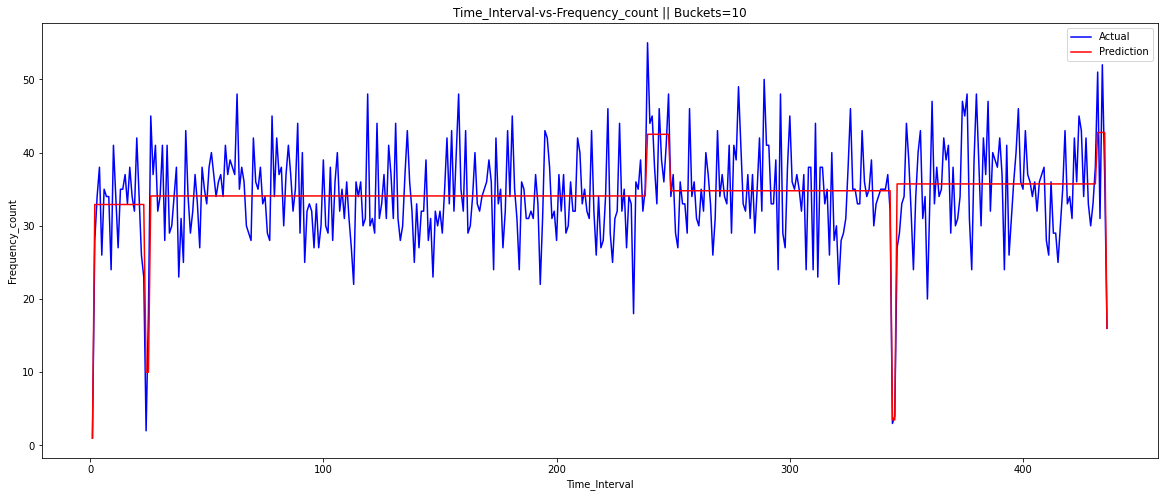

Average MSE =  27.937896978935353


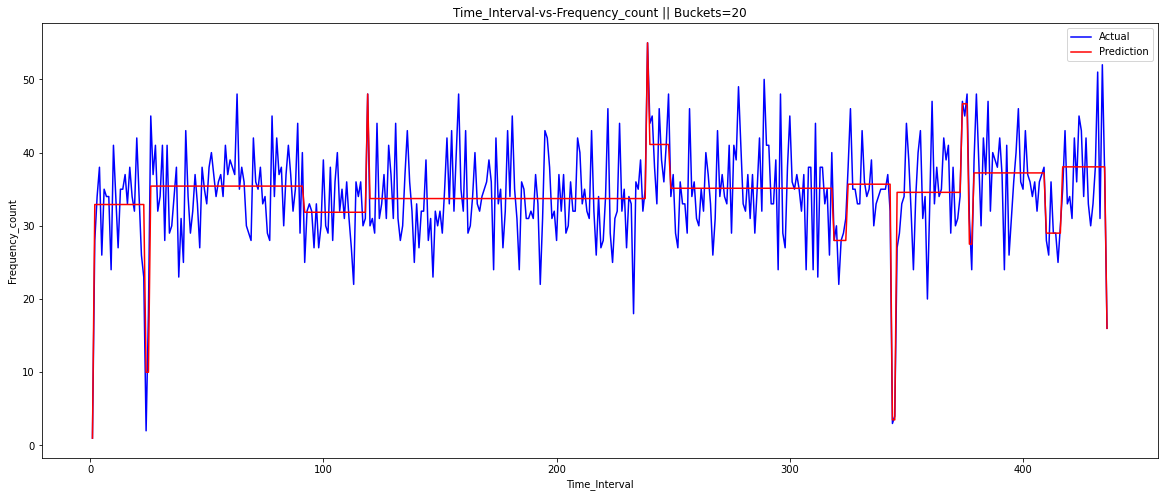

Average MSE =  24.91574582301513


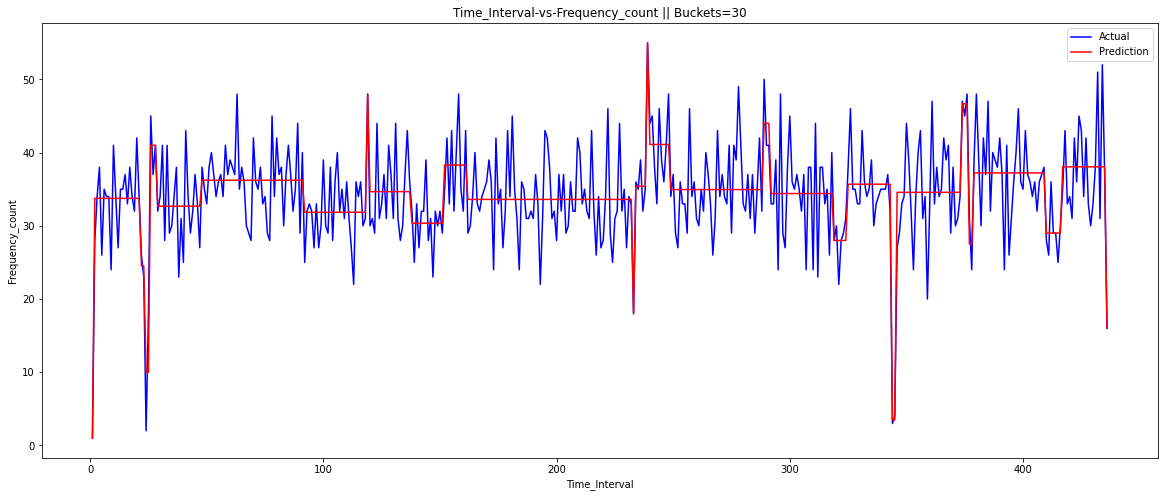

Average MSE =  22.196522968446683


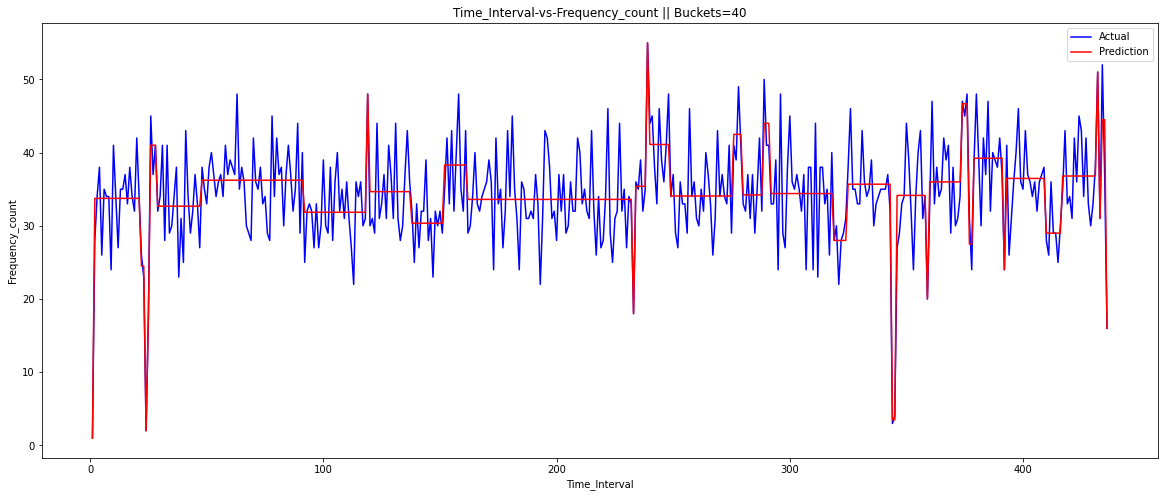

Average MSE =  19.899378952757896


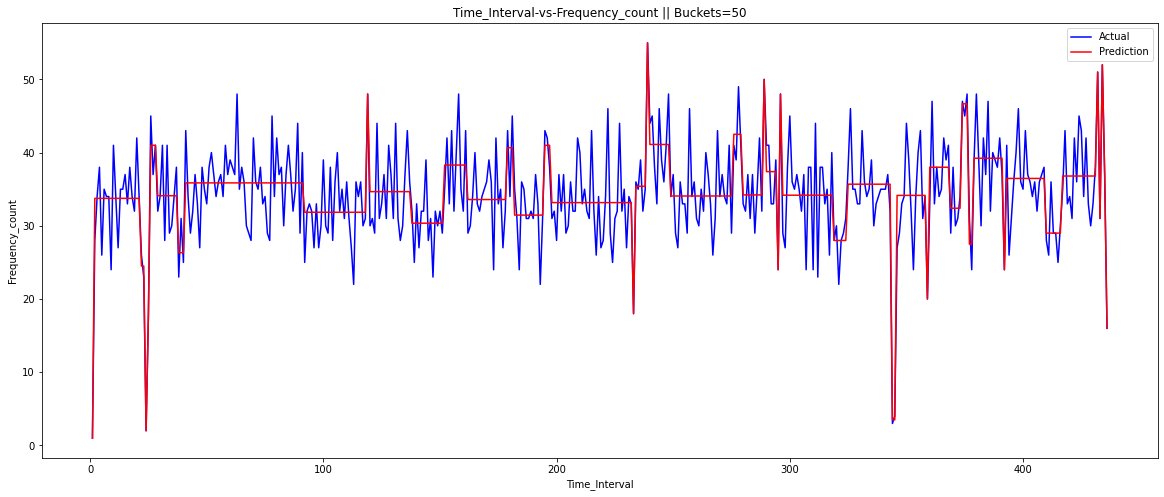

Average MSE =  17.880556257792485


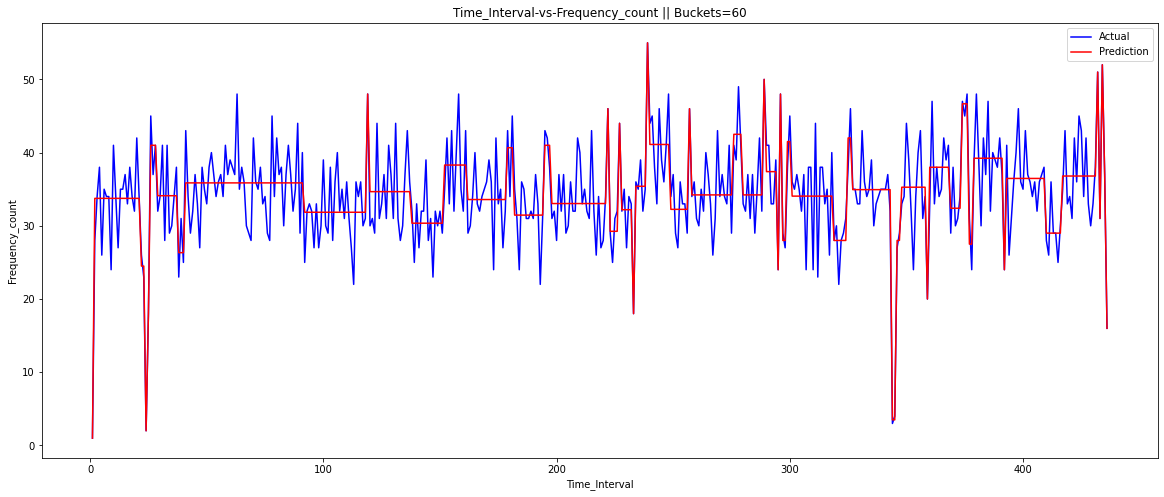

Average MSE =  15.971910092099431


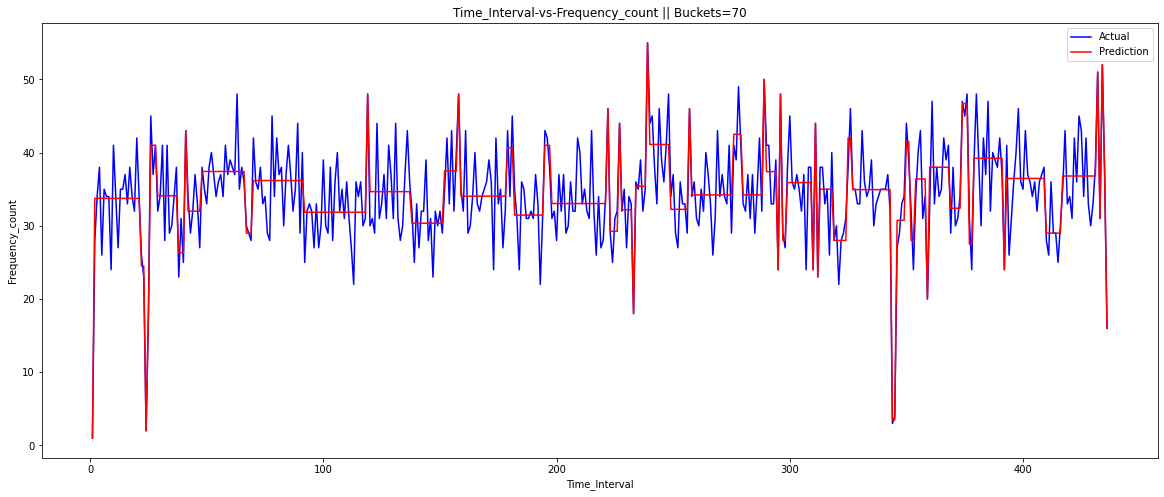

Average MSE =  14.227005727034674


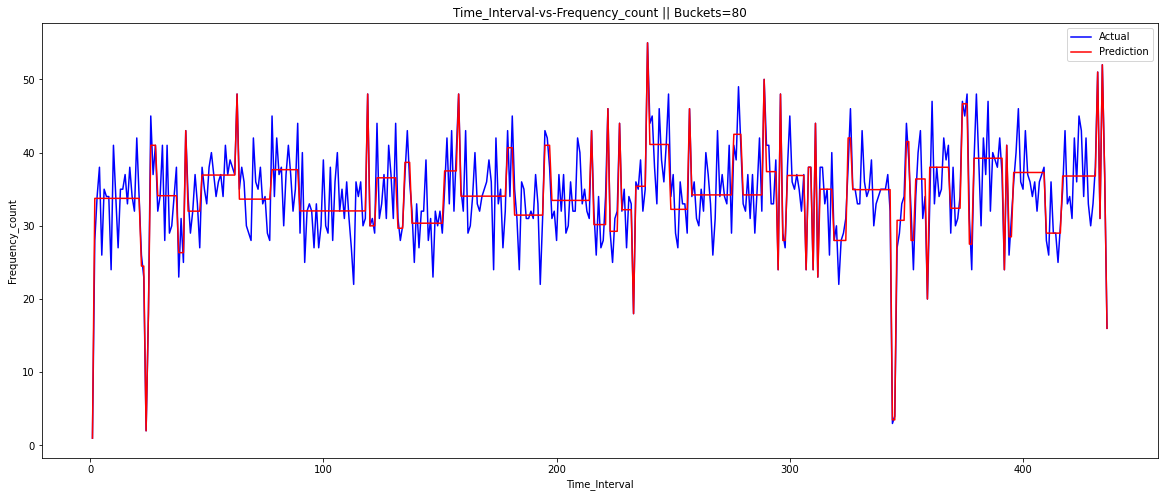

Average MSE =  12.710032889804143


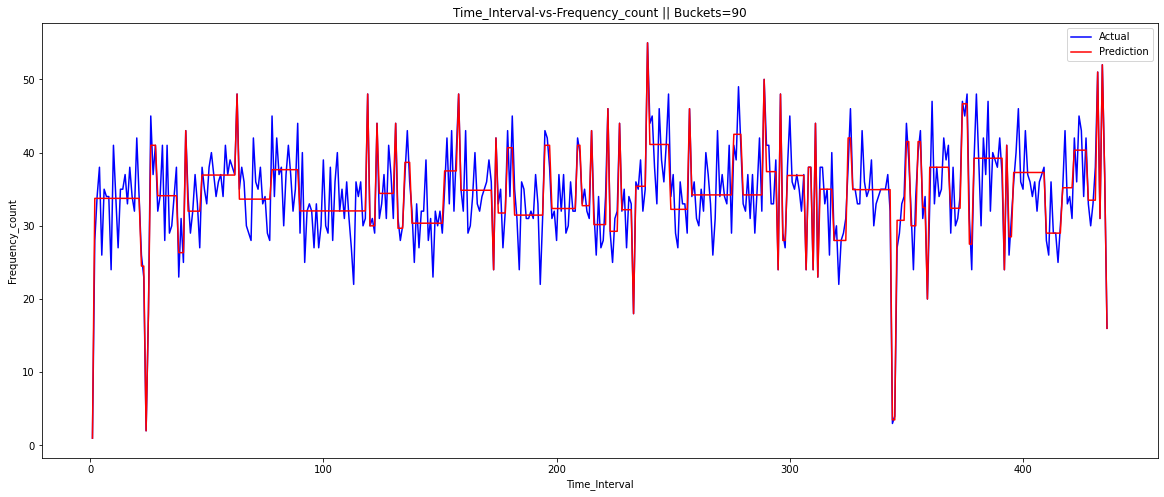

In [7]:
def predictor(bucket,bin_no):
    high = 0
    low = len(cumSum)-1
    while low>=bin_no:
        temp = tracer[bucket-1][low]
        high = low
        low = temp
        bucket-=1
    pred, actual = (cumSum[high] - cumSum[low])/(high-low), rows[bin_no-1] 
    err = abs(pred-actual)**2
    return pred, actual, err
def plotter(buc):
    act = []
    pred = []
    xaxis = np.linspace(1,len(rows),len(rows)).astype("int64")
    toterr = 0
    for i in xaxis:
        pr, ac, err = predictor(buc,i)
        #print("Pred : ",pr,",  Actual : ",ac,",  Error : ", err)
        act.append(ac)
        pred.append(pr)
        toterr+=err
    print("Average MSE = ", toterr/len(rows))
    plt.figure(figsize=(20, 8))
    plt.plot( xaxis, act,  "-b", label="Actual" )                                                   
    plt.plot( xaxis, pred, "-r", label="Prediction")
    plt.legend()
    plt.xlabel("Time_Interval")
    plt.ylabel("Frequency_count")
    plt.title("Time_Interval-vs-Frequency_count || Buckets="+str(buc)) 
    plt.savefig(str(buc)+'.png')
    plt.show()
    
plotter(10)
plotter(20)
plotter(30)
plotter(40)
plotter(50)
plotter(60)
plotter(70)
plotter(80)
plotter(90)